In [1]:
import get_news
import pandas as pd
from pprint import pprint

In [4]:
df.tail()

,timestamp,headline,link,content
66,"Last updated January 01, 2020 19:09:17 AEDT",The ugly side of New Year’s Eve,https://www.adelaidenow.com.au/news/south-aust...,"To use this website, cookies must be enabled i..."
67,"Last updated January 01, 2020 19:09:18 AEDT",2020: Australian capital cities memorable New ...,https://www.news.com.au/lifestyle/2020-austral...,Capital cities around Australia have welcomed ...
68,"Last updated January 01, 2020 19:09:20 AEDT",2019: The moments you can't miss,https://www.news.com.au/national/2019-the-mome...,"Watch the best, biggest, saddest and happiest ..."
69,"Last updated January 01, 2020 19:09:21 AEDT",The end of a decade: Looking back at the 2010s,https://www.news.com.au/world/decadewrapv4/vid...,The news that shaped the decade A NOTE ABOUT R...
70,"Last updated January 01, 2020 19:09:22 AEDT",Out-of-control infernos threaten homes and liv...,https://www.news.com.au/breaking-news/outofcon...,"Bushfires continue to burn across the country,..."


In [5]:
new_path = './news_20191220.pkl'
#df = get_news.incrental_load('./news_20191220.pkl')

# Incrementally loading data
df = pd.read_pickle(new_path)

## Stem/Tokenise

Tokenise is basically a function converts sentses into "tokens" or a list of words. In function below we did **stem** on top of the tokenised words, and removed **stop words** from the tokens

In [9]:
import nltk
import re
from nltk.tokenize import punkt
from nltk.stem import SnowballStemmer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from nltk.stem import WordNetLemmatizer 
  
#sample = df.sample(1).content.iloc[0]
keep = re.compile('[a-zA-Z]')

ps = PorterStemmer()
lemmatizer = WordNetLemmatizer() 

def stem_tokenise(corpus):    
    return [lemmatizer.lemmatize(ps.stem(w.lower())) for w in word_tokenize(corpus) if re.match(keep, w)]

# stem tokenise the stop words as well
stop_words = stem_tokenise(" ".join(list(set(stopwords.words('english')))))

In [7]:
import spacy

def cleansing(text):    
    # Remove Emails
    text = re.sub('\S*@\S*\s?', '', text) 

    # Remove new line characters
    text = re.sub('\s+', ' ', text)

    # Remove distracting single quotes
    text = re.sub("\'", "", text)
    
    return text

data = df.content.map(cleansing).map(lambda x: " ". join(stem_tokenise(x)))


def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download en
#nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
#data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
#print(data_lemmatized[:2])



In [8]:
print(data.to_list()[350])

one night a woman heard blind rattl in the room next door hour later her neighbour s bodi wa found in a pool of blood warn graphic how mani australian die by homicid each year and the horrifi way they are lose their live peter dupa arriv at the suprem court.sourc news limit warn graphic thi octob it final look like polic would be abl to have their day in court over the shock nurs home murder of kathleen down have charg one of australia s most deprav serial killer mr down had live at the brunswick lodg nurs home on quiet loyola ave for eight year becom known a the matriarch of the commun despit her age she wa still sprite a person who wa abl to get up and get about a she wa later describ geoff down son of kathleen down who wa stab three time in the neck the onli suspect is peter dupa and the famili is call for an inquest.sourc news limit a is custom a member of staff check on mr down at on new year s eve and found her soundli sleep at anoth resid heard blind rattl and a door open no dou

## SKlearn DTM

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

Below is an example of sklearn LDA, the problem is it is pretty slow and not as customisable compared to gensim.

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# use own tokeniser and stopwords (note: do the same processing for stop words)
#cv = CountVectorizer(stop_words=stop_words, tokenizer=stem_tokenise)

cv = CountVectorizer(analyzer='word',       
         min_df=10,                        # minimum reqd occurences of a word 
         stop_words='english',             # remove stop words
         lowercase=True,                   # convert all words to lowercase
         token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
         # max_features=50000,             # max number of uniq words
)


# get the dtm (coverting the matrix into dataframe)
data_cv = cv.fit_transform(data)
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index = df.index
#pprint(data_dtm)

# calculate the sparsity
data_dense = data_cv.todense()
# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  10.002603858444786 %


In [9]:
import numpy as np
row = data_dtm.iloc[300]
#pprint(row.nlargest(10))
#pprint(data.iloc[300])

## SKlearn Latent Direchlet Allocation

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html

In [10]:
# simple LDA
lda = LatentDirichletAllocation(n_components=10, max_iter = 10, learning_method = 'online', batch_size = 128, random_state=0)
lda_output = lda.fit_transform(data_cv)

In [11]:
print("log likelihood: ", lda.score(data_cv))
print("Perplexity: ", lda.perplexity(data_cv))
pprint(lda.get_params())

log likelihood:  -764181.611543143
Perplexity:  861.1281883103912
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 10,
 'n_jobs': None,
 'perp_tol': 0.1,
 'random_state': 0,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


### Perform a grid search

In [12]:
from sklearn.model_selection import GridSearchCV

search_params = {'n_components': [10, 20, 30], 'learning_decay': [0.5, 0.7, 0.9]}
lda = LatentDirichletAllocation()
model = GridSearchCV(lda, param_grid=search_params)
model.fit(data_cv)

#best model
best_model = model.best_estimator_

In [13]:
print("best model parameters: ", best_model.get_params())
result = pd.DataFrame(model.cv_results_)
result

best model parameters:  {'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.5, 'learning_method': 'batch', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 10, 'n_jobs': None, 'perp_tol': 0.1, 'random_state': None, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_decay,param_n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.366649,0.074122,0.060258,0.004730,0.5,10,"{'learning_decay': 0.5, 'n_components': 10}",-161380.468771,-210701.658833,-151637.343221,-156438.871855,-180977.714444,-172227.211425,21668.966619,1
1,2.690218,0.127891,0.088578,0.013848,0.5,20,"{'learning_decay': 0.5, 'n_components': 20}",-173423.058986,-222701.016014,-163130.730046,-168932.798929,-192217.347373,-184080.990269,21631.825161,6
2,2.890437,0.171532,0.093701,0.024805,0.5,30,"{'learning_decay': 0.5, 'n_components': 30}",-182919.450494,-233724.684915,-171945.065402,-177576.130563,-203536.396058,-193940.345486,22573.957796,9
3,2.405128,0.088040,0.062442,0.004668,0.7,10,"{'learning_decay': 0.7, 'n_components': 10}",-161680.121568,-211741.429131,-151839.296118,-156805.136779,-181488.795965,-172710.955912,21957.818138,3
4,2.590055,0.105922,0.075348,0.005511,0.7,20,"{'learning_decay': 0.7, 'n_components': 20}",-173165.693364,-222380.897942,-164006.374777,-168577.400714,-191554.180829,-183936.909525,21378.133180,5
5,2.777796,0.120739,0.097797,0.018055,0.7,30,"{'learning_decay': 0.7, 'n_components': 30}",-183096.967283,-233442.892811,-172204.366565,-178668.932610,-201494.370914,-193781.506037,22093.601233,8
6,2.445368,0.158330,0.062024,0.004535,0.9,10,"{'learning_decay': 0.9, 'n_components': 10}",-162739.524731,-210117.432453,-151785.989708,-157054.277526,-181415.118087,-172622.468501,21247.978750,2
7,2.416673,0.088158,0.070262,0.004311,0.9,20,"{'learning_decay': 0.9, 'n_components': 20}",-174153.072949,-222064.882707,-162825.258689,-168037.303476,-191915.478148,-183799.199194,21501.292088,4
8,2.666886,0.100634,0.090072,0.010212,0.9,30,"{'learning_decay': 0.9, 'n_components': 30}",-184373.489952,-232961.719332,-171770.095973,-178330.493216,-200981.567919,-193683.473278,21902.642259,7


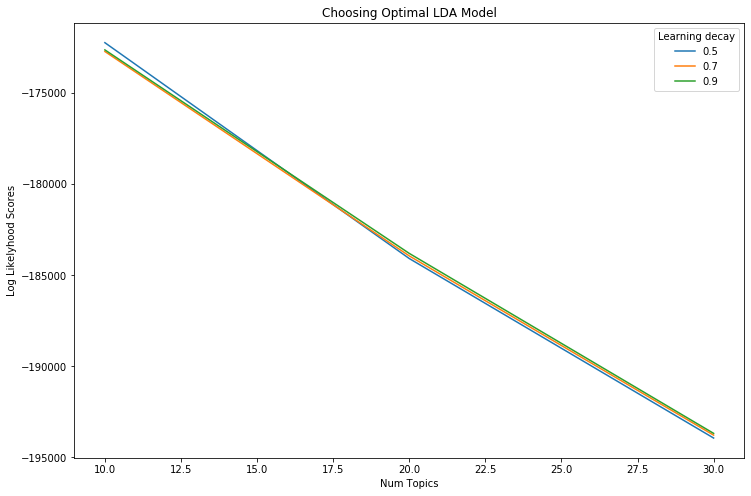

In [15]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 8))
for x in result.param_learning_decay.unique():
    plt.plot(result[result.param_learning_decay==x].param_n_components, result[result.param_learning_decay==x].mean_test_score, label=x)

plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

## Finding Dominate Topic

In [16]:
# Create Document - Topic Matrix
lda_output = best_model.transform(data_cv)

# column names
topicnames = ["Topic" + str(i) for i in range(best_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(df))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(20).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc0,0,0,0,0.52,0.22,0,0,0,0.25,0,3
Doc1,0.23,0,0,0.04,0.49,0,0,0.01,0,0.24,4
Doc2,0.07,0,0,0,0,0,0,0,0,0.92,9
Doc3,0,0,0,0,0,0,0,0,1,0,8
Doc4,0,0,0,0,0,0,0,0.93,0,0.06,7
Doc5,0,0,0,0,0,0,0,0.96,0,0.04,7
Doc6,0,0,0,0,0,0,0,0,0,1,9
Doc7,0,0,0,0,0,0,0,0.44,0.56,0,8
Doc8,0,0,0.1,0,0.35,0,0,0,0.54,0,8
Doc9,0,0,0,0,0,0.01,0,0.18,0.77,0.03,8


## Review Topics Distribution

In [17]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,8,134
1,7,58
2,6,51
3,4,40
4,1,24
5,9,14
6,2,11
7,3,9
8,0,9
9,5,5


## Visualize the LDA model with pyLDAvis

In [19]:
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_model, data_cv, cv, mds='tsne')

pyLDAvis.display(panel)

/usr/local/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [ ]:
topics = np.argmax(best_model.transform(data_cv), axis=1)

In [ ]:
topics